In [ ]:
import json
import zipfile
import os

# !pip install kaggle
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d austinreese/craigslist-carstrucks-data
! unzip craigslist-carstrucks-data.zip -d craigslist-carstrucks-data

Saving kaggle.json to kaggle (2).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
craigslist-carstrucks-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  craigslist-carstrucks-data.zip
replace craigslist-carstrucks-data/vehicles.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: craigslist-carstrucks-data/vehicles.csv  


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris

In [2]:
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import cufflinks as cf
cf.set_config_file(offline=True, sharing=False, theme='ggplot');

In [3]:
#visualising Raw Data
# raw=pd.read_csv("/content/craigslist-carstrucks-data/vehicles.csv")
# raw.info()
# raw.describe(include='all')


In [4]:
# reading cvs file and removing nan values that are other than the normal format

missing_value_formats = ["n.a.","?","NA","n/a", "na", "--","nan"]
df = pd.read_csv("/content/craigslist-carstrucks-data/vehicles.csv", na_values = missing_value_formats)

In [5]:
df = df[df['year'] >= 2015]
df1 = df[df['price'] > 0]


df1 = df1.drop(columns=["url","region_url","image_url","description","county","paint_color", "region","size","vin","transmission"],axis=1)
df1.dropna(axis=0, inplace=True)

#removing duplicates
df1=df1[df1.duplicated(subset=["price","year","manufacturer","model","condition","cylinders","fuel","odometer","title_status","drive","type","state"],keep= "first")==False]

# make numeric columns for the string columns to find correlations. using the unique values created above to do that
df1.replace(['good' ,'fair' ,'excellent' ,'like new' ,'salvage' ,'new'], [2,1,3, 4, 0, 5], inplace=True)
df1.replace(['8 cylinders' ,'6 cylinders' ,'4 cylinders' ,'5 cylinders' ,'10 cylinders' ,'other' ,'3 cylinders', '12 cylinders'], [8,6,4, 5, 10,0,3,12], inplace=True)
#condtion changed to 0 to 5 scale.

In [8]:
def normalize(df_column):
  range = df_column.max()-df_column.min()
  return df_column.apply(lambda x: (x-df_column.min())/range )
def OHE(df_column):
  return pd.get_dummies(df_column)

In [9]:
normalized_odometer = normalize(df1.odometer)
normalized_price = normalize(df1.price)
OHE_state = OHE(df1.state)
OHE_condition = pd.get_dummies(df1.condition)
OHE_type = pd.get_dummies(df1['type'])
OHE_title_status = pd.get_dummies(df1.title_status)
OHE_manufacturer = OHE(df1.manufacturer)
OHE_model = OHE(df1.model)
OHE_drive = OHE(df1.drive)

In [10]:
final_data = [df1.price,normalized_odometer,OHE_state,OHE_condition,OHE_type,OHE_drive,OHE_title_status,df1.year]
final_df = pd.concat(final_data, axis=1)
# final_df.drop(0,axis=1,inplace=True)
final_df_test = final_df[final_df.year >= 2019]
final_df = final_df[final_df.year < 2019]


In [11]:
print(final_df.shape)
print(final_df_test.shape)

(14538, 82)
(2951, 82)


In [12]:
final_df.drop('year', axis=1)
final_df_test.drop('year', axis=1)

final_df.reset_index(inplace=True,drop=True)
final_df_test.reset_index(inplace=True,drop=True)

In [13]:
import sklearn

X = final_df.copy().drop('price', axis=1)
X_test = final_df_test.copy().drop('price', axis=1)
Y_test = final_df_test["price"]
Y = final_df["price"]
model = LinearRegression()
model.fit(X,Y)
Y_pred = model.predict(X_test)
# print("Testing accuracy is",accuracy_score(Y_pred,Y[:2]))
sklearn.metrics.mean_absolute_error(y_true=Y_test,y_pred=Y_pred)

7843.155879362927

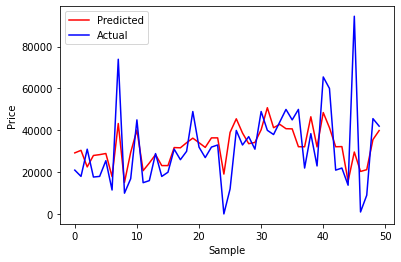

In [14]:
plt.plot(Y_pred[:50],'r-',label='Predicted')
plt.plot(Y_test[:50],'b-',label='Actual')
plt.ylabel('Price')
plt.xlabel('Sample')
plt.legend()
plt.show()

In [15]:
OHE_manufacturer.columns

Index(['acura', 'alfa-romeo', 'aston-martin', 'audi', 'bmw', 'buick',
       'cadillac', 'chevrolet', 'chrysler', 'dodge', 'fiat', 'ford', 'gmc',
       'honda', 'hyundai', 'infiniti', 'jaguar', 'jeep', 'kia', 'land rover',
       'lexus', 'lincoln', 'mazda', 'mercedes-benz', 'mini', 'mitsubishi',
       'nissan', 'porche', 'ram', 'rover', 'subaru', 'tesla', 'toyota',
       'volkswagen', 'volvo'],
      dtype='object')

In [25]:
missing_value_formats = ["n.a.","?","NA","n/a", "na", "--","nan"]
df = pd.read_csv("/content/craigslist-carstrucks-data/vehicles.csv", na_values = missing_value_formats)
# df = df[df['year'] >= 2016]
df1 = df[df['price'] > 0]


df1 = df1.drop(columns=["url","region_url","image_url","description","county","paint_color", "region","size","vin","transmission"],axis=1)
df1.dropna(axis=0, inplace=True)

#removing duplicates
df1=df1[df1.duplicated(subset=["price","year","manufacturer","model","condition","cylinders","fuel","odometer","title_status","drive","type","state"],keep= "first")==False]

# make numeric columns for the string columns to find correlations. using the unique values created above to do that
# df1.replace(['good' ,'fair' ,'excellent' ,'like new' ,'salvage' ,'new'], [2,1,3, 4, 0, 5], inplace=True)
df1.replace(['8 cylinders' ,'6 cylinders' ,'4 cylinders' ,'5 cylinders' ,'10 cylinders' ,'other' ,'3 cylinders', '12 cylinders'], [8,6,4, 5, 10,0,3,12], inplace=True)
#condtion changed to 0 to 5 scale.

In [26]:
normalized_odometer = normalize(df1.odometer)
normalized_price = normalize(df1.price)
OHE_state = OHE(df1.state)
OHE_condition = pd.get_dummies(df1.condition)
OHE_type = pd.get_dummies(df1['type'])
OHE_title_status = pd.get_dummies(df1.title_status)
OHE_manufacturer = OHE(df1.manufacturer)
OHE_model = OHE(df1.model)
OHE_drive = OHE(df1.drive)

In [27]:
logReg_data = [normalized_price,normalized_odometer,OHE_type,OHE_manufacturer,OHE_drive,df1.year]
logReg_df = pd.concat(logReg_data, axis=1)

logReg_df_test = logReg_df[logReg_df.year >= 2019]
logReg_df = logReg_df[logReg_df.year < 2019]

test_df = df1[df1['year'] >= 2019]
train_df = df1[df1['year'] < 2019]

X_logReg = logReg_df.copy()
Y_logReg = train_df.condition

X_logReg_test = logReg_df_test.copy()
Y_logReg_test = test_df.condition


X_logReg_test.drop('year', axis=1)
X_logReg.drop('year', axis=1)

X_logReg_test.reset_index(inplace=True,drop=True)
X_logReg.reset_index(inplace=True,drop=True)

In [28]:
clf = LogisticRegression(penalty= 'none').fit(X_logReg,Y_logReg)
test_Y_pred = clf.predict(X_logReg_test)

print("Testing acc is",accuracy_score(Y_logReg_test,test_Y_pred))
print("Confusion matrix is\n",confusion_matrix(Y_logReg_test,test_Y_pred))

Testing acc is 0.46289393425957304
Confusion matrix is
 [[597   0 354   0   0   0]
 [  1   0   0   0   0   0]
 [179   0 769   0   0   0]
 [571   0 326   0   0   0]
 [ 87   0  65   0   0   0]
 [  2   0   0   0   0   0]]


In [20]:
# np.array(test_Y_pred)

In [21]:
Y_logReg_test.shape

(2951,)

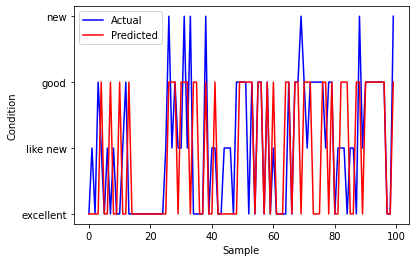

In [30]:
plt.plot(np.array(Y_logReg_test[:100]),'b-',label='Actual')
plt.plot(np.array(test_Y_pred[:100]),'r-',label='Predicted')
plt.ylabel('Condition')
plt.xlabel('Sample')
plt.legend()
plt.show()